In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brute, minimize
import os

In [16]:
def drvs_2(values, params):
    elk, wolves = values
    elk_prop, elk_wolf, wolf_elk, wolf_die = params

    elk_drv = elk_prop * elk - elk_wolf * wolves * elk
    wolves_drv = wolf_elk * wolves * elk - wolf_die * wolves

    return elk_drv, wolves_drv

In [77]:
def drvs_3(values, params):
    elk, wolves, bison = values
    elk_prop, elk_wolf, elk_bison, bison_prop, bison_wolf, bison_elk,  wolf_elk, wolf_bison, wolf_die = params

    elk_drv = elk_prop * elk - elk_wolf * wolves * elk - elk_bison * elk * bison
    bison_drv = bison_prop * bison - bison_wolf * wolves * bison - bison_elk * elk * bison
    wolves_drv = wolf_elk * wolves * elk + wolf_bison * wolves * bison - wolf_die * wolves

    # print("elkdrv: ", elk_drv, "wolfdrv: ", wolves_drv)
    return elk_drv, bison_drv, wolves_drv

In [17]:
def runge_kutta(values, params, time, step, drvs):
    values_lists = [[] for x in range(len(values))]
    
    for i in range(len(time)):
        k_1 = np.array(drvs(values, params))
        k_2 = np.array(drvs(values + step * k_1 / 2, params))
        k_3 = np.array(drvs(values + step * k_2 / 2, params))
        k_4 = np.array(drvs(values + step * k_3, params))

        values = values + step * (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6

        for value_it in range(len(values)):
            values_lists[value_it].append(values[value_it])

    # print(values_lists)

    return tuple(values_lists)

In [145]:
OPTIM_2_FUNC_VALUES = []

def lse_2_args(params, elk, wolves):
    global values_init
    global time
    global OPTIM_2_FUNC_VALUES
    elk_pred, wolves_pred = runge_kutta(values_init, params, time, 1, drvs_2)
    tmp_val = np.sum((elk - elk_pred)**2) + np.sum((wolves - wolves_pred)**2)
    OPTIM_2_FUNC_VALUES.append(tmp_val)
    return tmp_val

def mape_2_args(params, elk, wolves):
    global values_init
    global time
    global OPTIM_2_FUNC_VALUES
    elk_pred, wolves_pred = runge_kutta(values_init, params, time, 1, drvs_2)
    tmp_val = np.mean(np.abs((elk - elk_pred) / elk)) + np.mean(np.abs((wolves - wolves_pred) / wolves))
    OPTIM_2_FUNC_VALUES.append(tmp_val)
    return tmp_val

In [146]:
OPTIM_3_FUNC_VALUES = []

def lse_3_args(params, elk, bison, wolves):
    global values_init
    global time
    global OPTIM_3_FUNC_VALUES
    elk_pred, bison_pred, wolves_pred = runge_kutta(values_init, params, time, 1, drvs_3)
    tmp_val = np.sum((elk - elk_pred)**2) + np.sum((wolves - wolves_pred)**2) + np.sum((wolves - wolves_pred)**2)
    OPTIM_3_FUNC_VALUES.append(tmp_val)
    return tmp_val

def mape_3_args(params, elk, bison, wolves):
    global values_init
    global time
    global OPTIM_3_FUNC_VALUES
    elk_pred, bison_pred, wolves_pred = runge_kutta(values_init, params, time, 1, drvs_3)
    tmp_val = np.mean(np.abs((elk - elk_pred) / elk)) + np.mean(np.abs((bison - bison_pred) / bison)) + np.mean(np.abs((wolves - wolves_pred) / wolves))
    OPTIM_3_FUNC_VALUES.append(tmp_val)
    return tmp_val

In [19]:
path_to_file = "./datasets/yellowstone_park.csv"
dataframe = pd.read_csv(path_to_file)

DEVIDER = 1000

dataframe['wolves'] = dataframe['wolves'] / DEVIDER
dataframe['elk'] = dataframe['elk'] / DEVIDER
dataframe['bison'] = dataframe['bison'] / DEVIDER

wolves_init = dataframe['wolves'].iloc[0]
elk_init = dataframe['elk'].iloc[0]
bison_init = dataframe['bison'].iloc[0]

wolves_actual = dataframe['wolves']
elk_actual = dataframe['elk']
bison_actual = dataframe['bison']

time = dataframe["year"]
# print(elk_actual)
# time
dataframe

,year,elk,wolves,bison
0,1995,19.0,0.021,0.6
1,1996,16.0,0.030,0.7
2,1997,14.0,0.040,0.8
3,1998,12.0,0.055,0.9
4,1999,11.8,0.072,1.0
5,2000,14.2,0.096,1.1
6,2001,13.1,0.120,1.2
7,2002,12.0,0.142,1.3
8,2003,9.3,0.170,1.5
9,2004,8.2,0.179,1.7


Optimization terminated successfully.
         Current function value: 0.390900
         Iterations: 181
         Function evaluations: 316
[0.02036867 0.99702732 0.02891793 0.26696587]


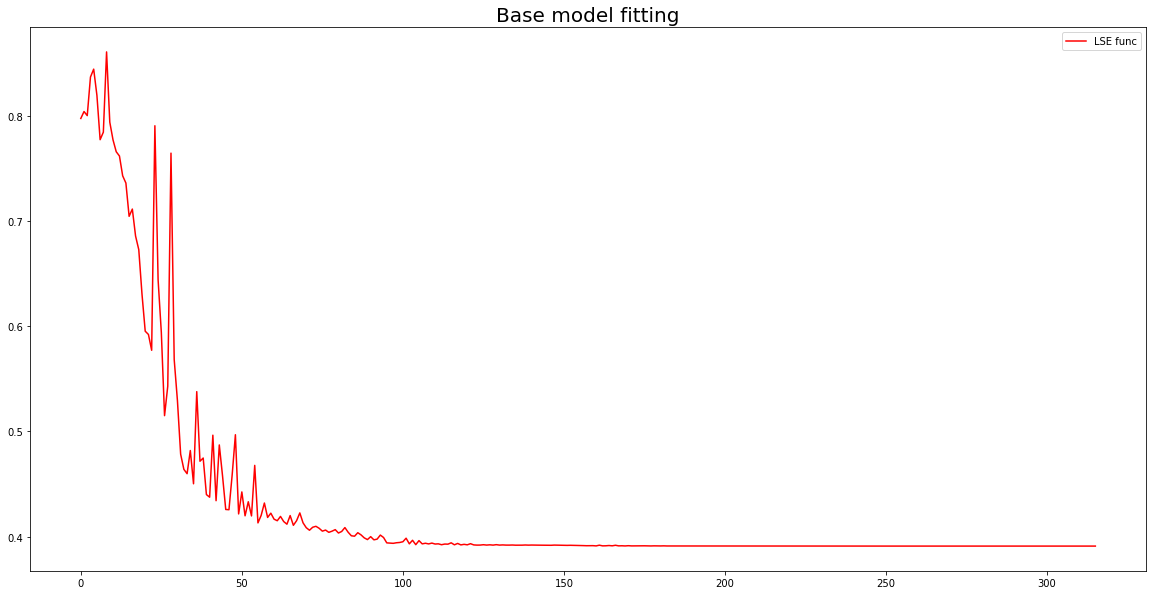

In [152]:
# Case for twi species
# Set some initial parameters

values_init = elk_init, wolves_init

values_actual = elk_actual, wolves_actual

# Taken from bruteforce
params_2 = (0.0325, 0.8, 0.05, 0.6)
# params_2 = (4.71558816e-04, 8.09334723e-01, 3.01923365e-02, 2.69416619e-01)

# Apply optimization for parameters
if params_2 == []:
    res_brute = brute(mape_2_args, ((0, 1), (0, 1), (0, 1), (0, 1)), args=((values_actual)), Ns=20, full_output=True)
    params_2 = res_brute[0]
    print("Bruteforced:", params_2)

# Need to save optimisation data
OPTIM_2_FUNC_VALUES = []
# Apply optimization with initial guess
res_2 = minimize(mape_2_args, params_2,
                args=((values_actual)), bounds=((0, 1), (0, 1), (0, 1), (0, 1)), method='Nelder-Mead', tol=1e-6, options={'disp': True})

params_2 = res_2.x
print(params_2)

plt.figure(figsize=(20, 10))
plt.title('Base model fitting', fontsize=20)
plt.plot(np.arange(0, len(OPTIM_2_FUNC_VALUES)), OPTIM_2_FUNC_VALUES, color='red', label='LSE func')
plt.legend()
plt.show()

In [151]:
FORECAST_YEAR = 2150

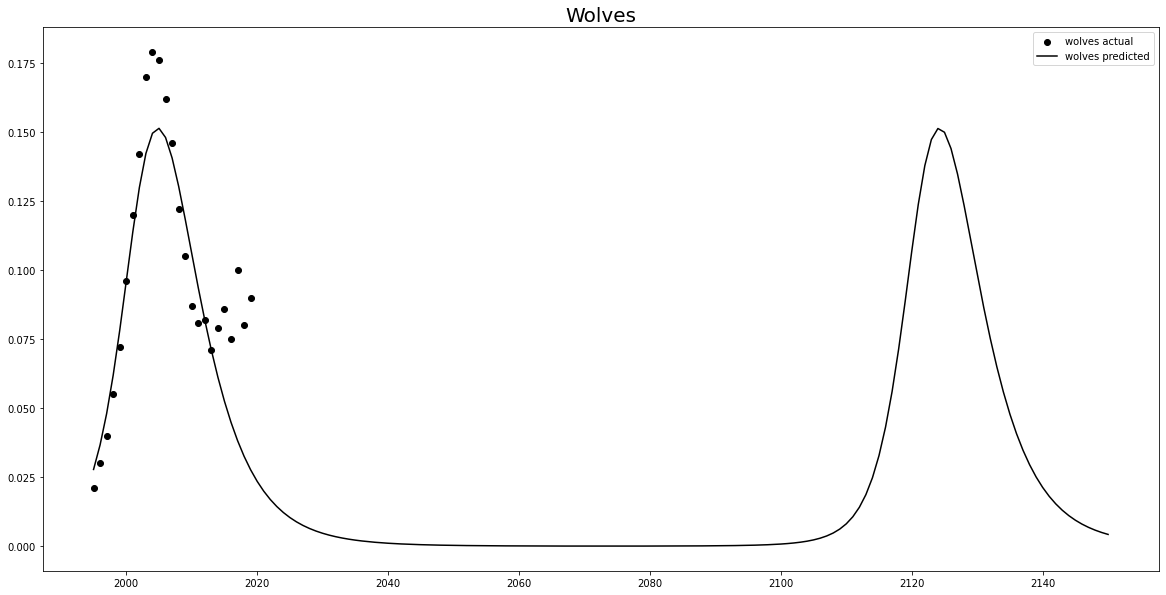

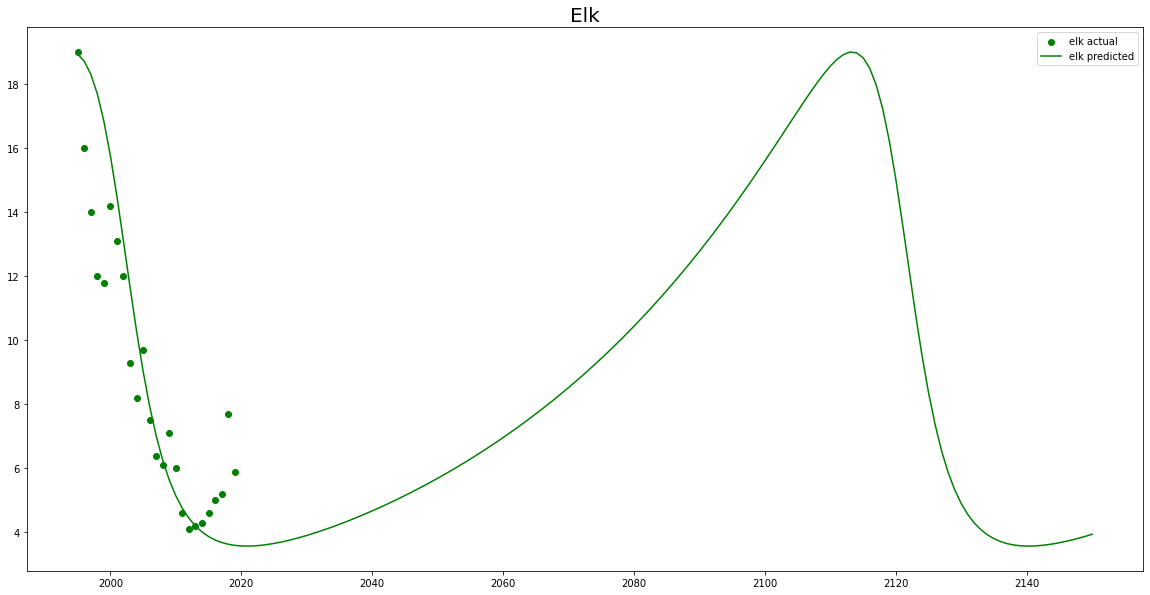

In [153]:
# Make forecast, print and compare

forecast_time = np.linspace(time.iloc[0], FORECAST_YEAR, FORECAST_YEAR-time.iloc[0]+1)
elk_pred, wolves_pred = runge_kutta(values_init, params_2, forecast_time, 1, drvs_2)

plt.figure(figsize=(20, 10))
plt.title('Wolves', fontsize=20)
plt.scatter(time, wolves_actual,label='wolves actual', color="black")
plt.plot(forecast_time, wolves_pred, color='black', label='wolves predicted')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.title('Elk', fontsize=20)
plt.scatter(time, elk_actual,label='elk actual', color="green")
plt.plot(forecast_time, elk_pred, color='green', label='elk predicted')
plt.legend()
plt.show()




C:\Users\vando\AppData\Local\Temp/ipykernel_28408/2401154050.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  res = minimize(mape_3_args, params_3,


Optimization terminated successfully.
         Current function value: 1.049799
         Iterations: 1026
         Function evaluations: 1529
[1.08119412e-02 1.19228587e-01 4.92226098e-02 1.00000000e+00
 9.99997283e-01 5.69400018e-07 4.61706496e-04 0.00000000e+00
 0.00000000e+00]


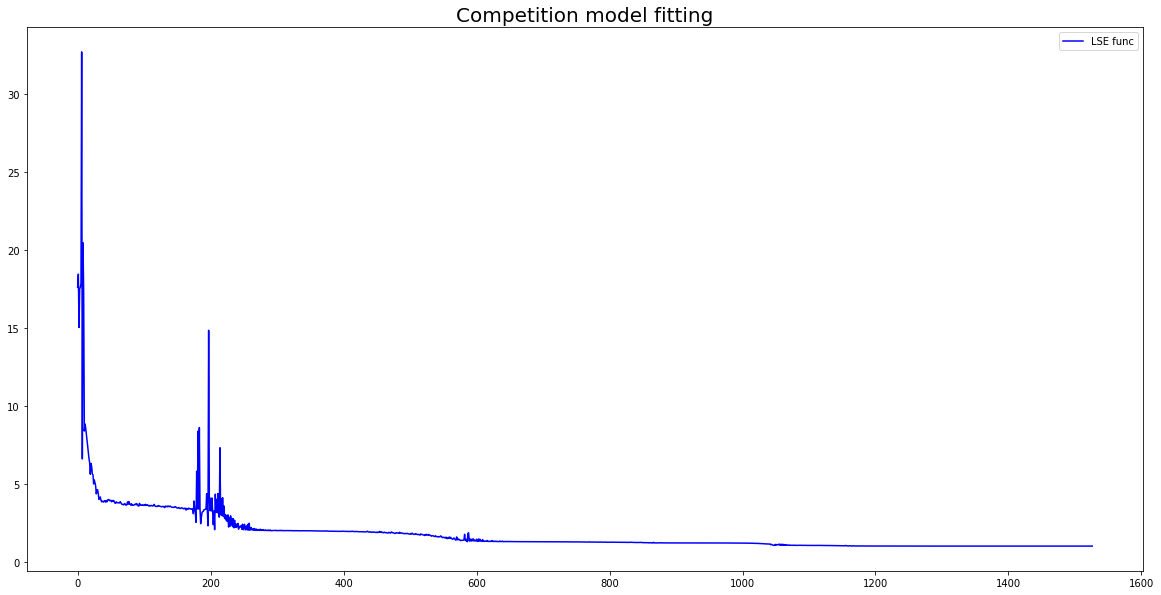

In [154]:
# Case for three species
# Set some initial parameters

values_init = elk_init, bison_init, wolves_init

values_actual = elk_actual, bison_actual, wolves_actual

# Taken from bruteforce
params_3 = ( 8.63509911e-03,  3.72995741e-01,  2.81869705e-02,  1.45161432e+00,
  8.55603166e-01,  2.57019568e-01, -4.27037293e-04,  4.10540307e-01,
 -4.20400013e-03)

# Apply optimization for parameters
if params_3 == []:
    res_brute = brute(mape_3_args, ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)), args=((values_actual)), Ns=5, full_output=True)
    params_3 = res_brute[0]
    print("Bruteforced:", params_3)

# Need to save optimisation data
OPTIM_3_FUNC_VALUES = []
# Apply optimization with initial guess
res = minimize(mape_3_args, params_3,
                args=((values_actual)), bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)), method='Nelder-Mead', tol=1e-6, options={'disp': True})

params_3 = res.x
print(params_3)
# Drop bad values
print_list = []
for item in OPTIM_3_FUNC_VALUES:
  if item < 100:
    print_list.append(item)

plt.figure(figsize=(20, 10))
plt.title('Competition model fitting', fontsize=20)
plt.plot(np.arange(0, len(print_list)), print_list, color='blue', label='LSE func')
plt.legend()
plt.show()

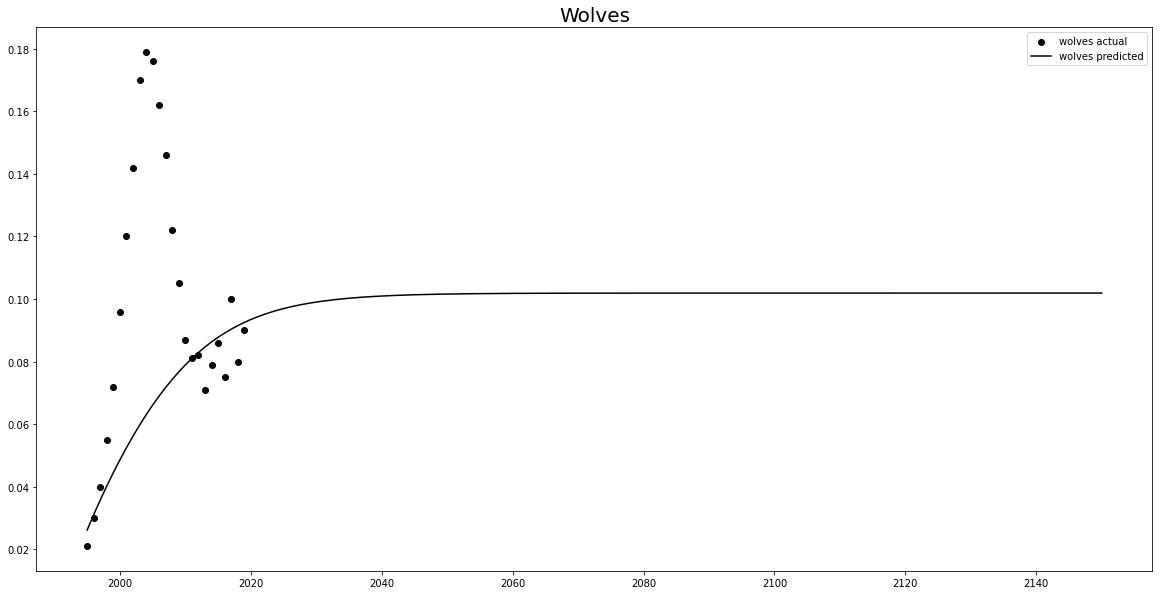

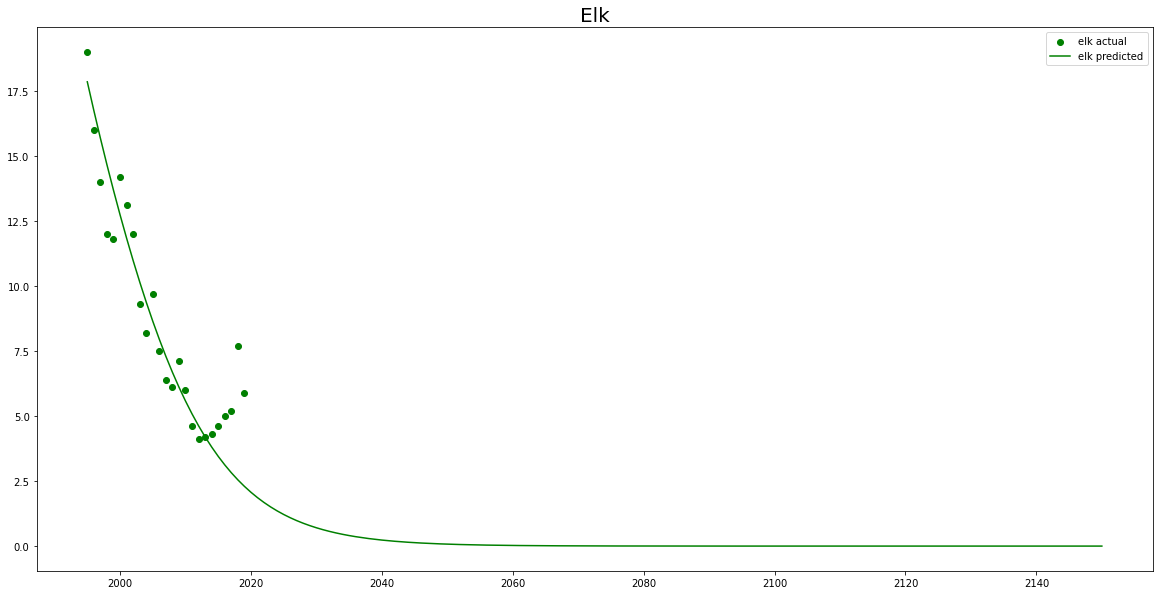

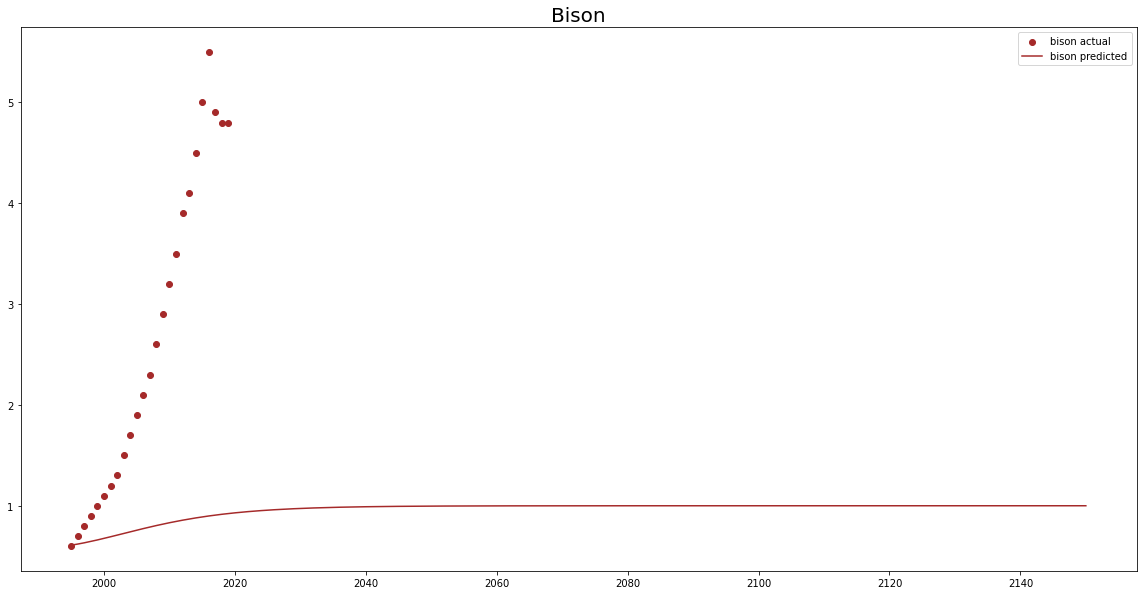

In [155]:
# Make forecast, print and compare
forecast_time = np.linspace(time.iloc[0], FORECAST_YEAR, FORECAST_YEAR-time.iloc[0]+1)
elk_pred, bison_pred, wolves_pred = runge_kutta(values_init, params_3, forecast_time, 1, drvs_3)

plt.figure(figsize=(20, 10))
plt.title('Wolves', fontsize=20)
plt.scatter(time, wolves_actual,label='wolves actual', color="black")
plt.plot(forecast_time, wolves_pred, color='black', label='wolves predicted')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.title('Elk', fontsize=20)
plt.scatter(time, elk_actual,label='elk actual', color="green")
plt.plot(forecast_time, elk_pred, color='green', label='elk predicted')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.title('Bison', fontsize=20)
plt.scatter(time, bison_actual,label='bison actual', color="brown")
plt.plot(forecast_time, bison_pred, color='brown', label='bison predicted')
plt.legend()
plt.show()


